Missing colon in file WindowsPath('D:/Anacond3/Lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 71 (' 取消注释')
Missing colon in file WindowsPath('D:/Anacond3/Lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 74 (' 取消注释，并将SimHei放到第一个')
Duplicate key in file WindowsPath('D:/Anacond3/Lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 272 ('font.family:  sans-serif')
Duplicate key in file WindowsPath('D:/Anacond3/Lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 280 ('font.sans-serif: DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')


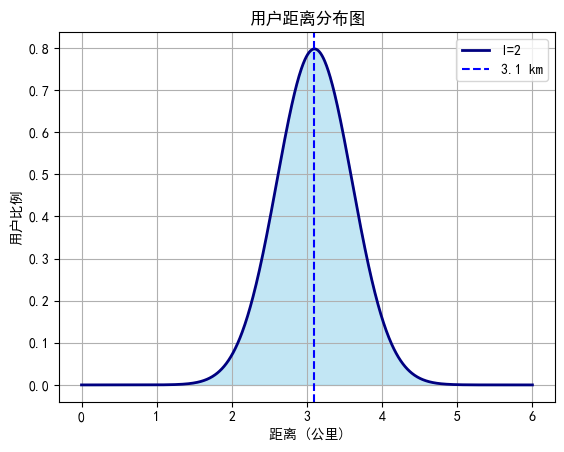

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# 定义平均值和标准差
mu = 3.1  # 平均距离，单位公里
sigma = 0.5  # 假设的标准差，单位公里
l = 2  # 标签或特定值

# 创建距离的值域，足够涵盖大部分概率质量
x = np.linspace(0, 6, 1000)

# 创建正态分布的概率密度函数
pdf = norm.pdf(x, mu, sigma)

# 绘制概率密度函数
plt.fill_between(x, pdf, color="skyblue", alpha=0.5)
plt.plot(x, pdf, label=f'l={l}', lw=2, color='navy')

# 用虚线标记平均距离
plt.axvline(mu, color='blue', linestyle='dashed', linewidth=1.5, label=f'{mu} km')

# 添加标签和标题
plt.xlabel('距离 (公里)')
plt.ylabel('用户比例')
plt.title('用户距离分布图')
plt.legend()

# 显示网格和图形
plt.grid(True)
plt.show()

In [83]:
import pandas as pd
import numpy as np
import folium
import os
import matplotlib.cm as cm

def get_lat_lon_bounds_from_bin(lat_bin, lon_bin, lat_bins, lon_bins, grid_size_lat, grid_size_lon):
    min_lat = lat_bins[lat_bin - 1]
    max_lat = lat_bins[lat_bin] if lat_bin < len(lat_bins) else lat_bins[lat_bin - 1] + grid_size_lat
    min_lon = lon_bins[lon_bin - 1]
    max_lon = lon_bins[lon_bin] if lon_bin < len(lon_bins) else lon_bins[lon_bin - 1] + grid_size_lon
    return min_lat, max_lat, min_lon, max_lon

# 加载Excel文件
file_path = 'C:/Users/21523/Desktop/浙江商业.xlsx'  # 请替换为您的文件路径
data = pd.read_excel(file_path)

# 定义网格大小
grid_size_lat = (data['纬度'].max() - data['纬度'].min()) / 50
grid_size_lon = (data['经度'].max() - data['经度'].min()) / 50

# 创建网格线
lat_bins = np.arange(data['纬度'].min(), data['纬度'].max(), grid_size_lat)
lon_bins = np.arange(data['经度'].min(), data['经度'].max(), grid_size_lon)

# 将每个点分配到一个网格中
data['lat_bin'] = np.digitize(data['纬度'], lat_bins)
data['lon_bin'] = np.digitize(data['经度'], lon_bins)

# 计算每个网格中的点的数量
heatmap_data = data.groupby(['城市', 'lat_bin', 'lon_bin']).size().reset_index(name='count')

# 找到每个城市热力值最高的栅格
max_heatmap_coords = []
for city, city_data in heatmap_data.groupby('城市'):
    max_row = city_data.loc[city_data['count'].idxmax()]
    min_lat, max_lat, min_lon, max_lon = get_lat_lon_bounds_from_bin(max_row['lat_bin'], max_row['lon_bin'], lat_bins, lon_bins, grid_size_lat, grid_size_lon)
    max_heatmap_coords.append({'城市': city, 'min_lat': min_lat, 'max_lat': max_lat, 'min_lon': min_lon, 'max_lon': max_lon})

# 创建以点的平均位置为中心的地图
map_center = [data['纬度'].mean(), data['经度'].mean()]
map_with_refined_grid = folium.Map(location=map_center, tiles='CartoDB positron', zoom_start=10)

# 创建自定义图例
legend_html = """
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 200px; height: 50px; 
                background-color: rgba(255, 255, 255, 0.5); /* 背景颜色设置为半透明白色 */
                border-radius: 10px; /* 边框圆角 */
                border:2px solid grey; z-index:9999; font-size:14px;">
        <div style="text-align: center;">Number of Visitors</div>
        <div style="text-align: center;">
            <div style="background: linear-gradient(to right, #FFFFCC, #FFCC00, #FF9900, #FF6600, #FF3300, #FF0000, #CC0000); width: 100%; height: 20px;"></div>
        </div>
    </div>
"""

map_with_refined_grid.get_root().html.add_child(folium.Element(legend_html))

# 使用颜色映射函数定义颜色
color_map = cm.get_cmap('YlOrRd')

# 存储热力值较高的栅格的经纬度范围
high_heatmap_coords = []

# 添加带有更新颜色的精细网格方格
for _, row in heatmap_data.iterrows():
    min_lat, max_lat, min_lon, max_lon = get_lat_lon_bounds_from_bin(row['lat_bin'], row['lon_bin'], lat_bins, lon_bins, grid_size_lat, grid_size_lon)
    if row['count'] >= 50:  # 如果热力值大于等于50，认为是高热力区域
        high_heatmap_coords.append({'min_lat': min_lat, 'max_lat': max_lat, 'min_lon': min_lon, 'max_lon': max_lon})  # 将高热力值栅格的经纬度范围添加到列表中
    
    # 计算颜色
    color = color_map(row['count'] / heatmap_data['count'].max())  # 使用数据归一化后的值来获取颜色
    color_hex = "#{:02x}{:02x}{:02x}".format(int(color[0]*255), int(color[1]*255), int(color[2]*255))  # 转换为十六进制颜色
    
    folium.Rectangle(
        bounds=[[min_lat, min_lon], [max_lat, max_lon]],
        fill=True,
        color=color_hex,
        fill_opacity=0.75,
        line_opacity=0.2
    ).add_to(map_with_refined_grid)

# 获取桌面路径
desktop_path = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop')

# 将精细网格地图保存为新的HTML文件
output_refined_grid_file_path = os.path.join(desktop_path, 'hangzhou_tourism_refined_grid_heatmap_YlOrRd.html')
map_with_refined_grid.save(output_refined_grid_file_path)
print(f"地图已保存至 {output_refined_grid_file_path}")

# 将热力值较高的栅格的经纬度范围保存到新文件中
high_heatmap_coords_df = pd.DataFrame(high_heatmap_coords)
high_heatmap_coords_file_path = os.path.join(desktop_path, 'high_heatmap_coords.csv')
high_heatmap_coords_df.to_csv(high_heatmap_coords_file_path, index=False)
print(f"高热力值栅格的经纬度范围已保存至 {high_heatmap_coords_file_path}")

C:\Users\21523\AppData\Local\Temp\ipykernel_14780\3692668885.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('YlOrRd')


地图已保存至 C:\Users\21523\Desktop\hangzhou_tourism_refined_grid_heatmap_YlOrRd.html
高热力值栅格的经纬度范围已保存至 C:\Users\21523\Desktop\high_heatmap_coords.csv


In [84]:
from selenium import webdriver
import time
import os

# 创建Chrome WebDriver实例
driver = webdriver.Chrome()

# 打开地图网页
map_file_path = "C:\\Users\\21523\\Desktop\\浙江商业.html"  # 地图HTML文件的路径
driver.get("file:///" + map_file_path)  

# 等待地图加载完成
time.sleep(15)  # 根据需要调整等待时间

# 将地图保存为屏幕截图
screenshot_file_path = os.path.join(os.path.expanduser('~'), 'Desktop', 'ningbo_map.png')
driver.save_screenshot(screenshot_file_path)

# 关闭浏览器
driver.quit()